# Keras
Keras is fairly well-known in the Python deep learning community. It used to be a high-level API to make frameworks like CNTK, Theano and TensorFlow easier to use and was framework-agnostic (you only had to set the backend for processing, everything else was abstracted). A few years ago, Keras was migrated to the TF repository and dropped support for other backends. It is now the de-facto high level API for TF.


### Layers and models
The basic component of a Keras model is a layer. A layer is comprised of one or more operations and is meant to be easily reusable. A model is a graph of layers.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

You'll see examples in the TF guide immediately start with neural networks. My own choice is to first see how to implement something really simple, like linear regression again.

The simplest way to construct a Keras model is a sequential model, which is just a sequence of layers (or operations). For simple models, this works well. Our linear regression model has just one layer - a [dense layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), which means a multiplication with a weight and a bias addition. This is exactly our equation: $y = wx+ b$.

This layer can also be used for neural networks, where we would be multiplying matrices. We choose `units = 1` (output a vector of size 1, i.e. a scalar for each example) and `input_shape = (1, )`, which means that we have 1 feature for each example.

In [ ]:
linear_layer = layers.Dense(
    units=1, 
    input_shape=(1,),
    name="linear_layer"
)

linear_model = models.Sequential([
    linear_layer
], name="linear_model")

# View the weights (parameters) of a layer
linear_layer.weights

Let's look a very useful method which gives us the summary of a model. It shows us all the layers + their shapes and the parameters of the model.

In [ ]:
linear_model.summary()

Before training, we need to specify the optimizer we will use and which loss we want to minimize. We'll choose the same as before: gradient descent and mean squared error. We do this by "compiling" the model, which prepares it for training. After that, we can call `.fit`, which is similar to scikit-learn. However, here we have to specify the number of iterations (epochs) we want to run.

In [ ]:
linear_model.compile(
    optimizer=keras.optimizers.SGD(lr=0.1),
    loss=keras.losses.MeanSquaredError(),
)

# Same data as before
x = tf.cast(tf.linspace(-1, 1, 21), tf.float32)
y = x + tf.random.uniform(x.shape, -0.05, 0.05, seed=117) + 2

# Run 50 iterations of GD updates
linear_model.fit(x, y, verbose=0, epochs=50)

y_hat = linear_model.predict(x)
mse = keras.metrics.MeanSquaredError()(y, y_hat)
print(f'MSE: {mse:.4f}')

sns.relplot(data = pd.DataFrame({'y_true': y, 'y_hat': np.reshape(y_hat, (-1, ))}))

We see that we also managed to get a good fit. Observe how we managed to do this by avoiding all optimization-related mathematics - we only had to specify how the model computes predictions (the forward pass). Since our model and optimization procedure were very simple, the code wasn't all that different, but for more advanced approaches, it's usually much simpler to use Keras.

### More details for layers and models

A layer holds state and performs computations. Layers should be easily reusable and composable - you can create more complex layers from simpler ones.
A model is a graph of layers and offers train / predict / evaluate APIs. It is easily serializable.

#### A custom layer example
Let's write a really simple custom layer - the argmax function. We'll wrap the plain `tf.argmax` function to do the heavy lifting. This layer could come in handy if we had probabilities and wanted to extract the most probable class. Each custom layer class should inherit from `tf.keras.layers.Layer` and implement at least the `call()` method where the forward pass is defined

In [ ]:
class ArgMax(layers.Layer):    
    # Define the forward pass
    def call(self, x):
        return tf.argmax(x, axis=1)

### MNIST example with the Functional API
A core principle of Keras is the progressive increase of complexity. You should always be able to get into lower-level workflows in a gradual way. You shouldn't fall off a cliff if the high-level functionality doesn't exactly match your use case. You should be able to gain more control over the small details while keeping some high-level convenience.

For more sophisticated usecases, we might want a more flexible way to construct models (recurrent models, multiple inputs and outputs...). We'll move onto the Functional API, which offers us just that. Instead of specifying a sequence of layers, we create each layer individually and apply it onto the previous ones. This is the most popular way of creating models in Keras and is recommended. Each layer is a Python class which you apply by calling it with its inputs. The inputs to each layer are tensors (`tf.Tensor`). Once you have all the layers applied, you simply create a model by telling it what is its input and its output. TensorFlow will find the path through the graph of layers you have created and note down which layers are part of the graph (unused parts will not be included).


#### Neural networks
Now, we'll move on to a neural network example. We'll classify handwritten digits from the [MNIST database](https://en.wikipedia.org/wiki/MNIST_database) with a fully-connected neural network consisting of 3 layers. Due to the simplicity of Keras, this won't be much more difficult than the linear regression example! We'll use only dense layers and ReLU & Softmax activation functions. In this example, our inputs will have 784 features, which are pixels of the 28x28 grayscale images. With matrix multiplication in the dense layers, we will transform them from a 784 to 10-dimensional space, which will be the class probabilities.

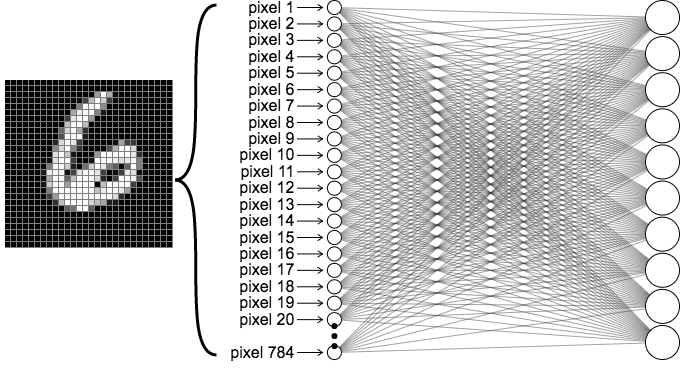

We need to start with the Input class, which is a placeholder for the actual data we'll send in. The shape we are specifying is the length of each vector (example). Even though we can (and should) feed in matrices of data, the batch size (the number of rows in the matrix) is always omitted in Keras.

In [ ]:
inputs = layers.Input(shape=(784,), name='digits')

# After we create a layer object, we get its output by calling it and passing the input tensor.
layer1 = layers.Dense(64, activation='relu', name='dense_1')
x1 = layer1(inputs)

# The activation function can also be added by creating a `layers.ReLU` or `layers.Activation` layer.
layer2 = layers.Dense(32, activation='relu', name='dense_2')
x2 = layer2(x1)

# Our outputs will be probabilities for all 10 digits.
# The softmax function transforms the outputs from real numbers to probabilities that sum to 1.
proba_predictions = layers.Dense(10, activation='softmax', name='predictions')(x2)

model = models.Model(inputs=inputs, outputs=proba_predictions, name='mnist_model')

model.summary()

You can access input / output / weights attributes on both layers and models to see what they contain.

In [ ]:
print(f'Layer 2: {layer2}\n')
print(f'Layer 2 inputs: {layer2.input}\n and outputs: {layer2.output}\n')
print(f'Model inputs: {model.input} and outputs: {model.output}\n')
print(f'Layer 2 weights: {layer2.weights}\n')

Keras has this dataset easily accessible.

In [ ]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test  shape: {y_test.shape}')

# Preprocess the data (these are Numpy arrays)
# Reshape each matrix into a vector and rescale onto [0, 1]
x_train = x_train.reshape(-1, 784).astype(np.float32) / 255
x_test = x_test.reshape(-1, 784).astype(np.float32) / 255

Again, we'll need to compile the model before training. We'll use a different optimizer and loss function this time. Lastly, we'll also add an accuracy metric so we can easily see how the training is going. Notice that we output 10 numbers for each example while the target is only one number - the class label. Luckily, the inbuilt sparse categorical loss and accuracy handle this for us out of the box.

In [ ]:
model.compile(
    # Optimizer: RMSprop
    optimizer=keras.optimizers.RMSprop(),  
    # Loss function to minimize: cross-entropy
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor: accuracy
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

Since we have plenty of data, we'll use a validation set (we don't train on it) to monitor the loss and accuracy. We'll also perform the training in minibatches.

In [ ]:
history = model.fit(
    x_train,
    y_train,
    batch_size=64,        # The minibatch size (tradeoff between speed and quality)
    epochs=2,            
    validation_split=0.2  # How much of the training data to use for validation
)

# Show the loss and metrics history
history.history

The validation results seem good. To make sure, we'll also evaluate our model on the test set.

In [ ]:
# Evaluate the model on the test data
loss, acc = model.evaluate(x_test, y_test, batch_size=128)
print(f'Evaluation results: test loss {loss}, test accuracy {acc}\n')

# Generate predictions (probabilities - the output of the last layer) on new data
predictions = model.predict(x_test[:10])
print(f'Predictions {predictions[:3]} \nwith shape {predictions[:3].shape}\n')
print(f'Ground truth: {y_test[:10]}')

Our model gives us a vector of length 10 (the probability of each of the 10 digits). Looking through this is perhaps a bit cumbersome and we might want the most likely digit as an output by default. We could modify our model to output the digit with the highest probability, but we can also extend it by adding a new final layer. This gives us a new model that actually shares weights with the already trained model, which is quite useful!

In [ ]:
# Luckily, we already implemented this layer :)
# It gives us the index of the highest value in each row of the input, which is the most probable class of that row.
argmax_layer = ArgMax(name="mnist_argmax")

# Reuse the already trained model by calling the argmax layer on its output
model_class_pred = models.Model(inputs=inputs, outputs=argmax_layer(model.output), name="mnist_class_pred_model")
model_class_pred.summary()

print(f'Class predictions: {model_class_pred.predict(x_test[:10])}')

We got our predictions in the form of class labels. Looking above, we can see that they look fairly close to the truth.

### Going further
The [Keras API docs](https://www.tensorflow.org/api_docs/python/tf/keras) are pretty nice and contain a lot more material - definitely check out the list of layers. And even if you can't find something you need - it's easy to create your own layer, metric or loss function with plain TF operations.